In [1]:
import tensorflow as tf
import tensorflow_datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (
    Resizing,
    Rescaling,
    Lambda,
    RandomFlip,
    RandomRotation,
    RandomZoom,
    RandomTranslation,
    MaxPooling2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    Dropout, Input
)

from tf.keras.models import load_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Dogs and cats light dataset
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip',  # name of downloaded zip
                                      origin=_URL, 
                                      extract=True,  # extracting files
                                      cache_dir='.') # it ensures, that it will be dwonloaded to current directory
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered') 

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


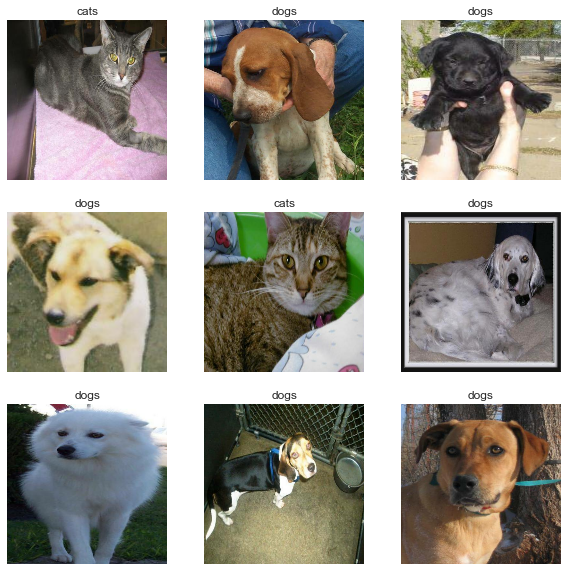

In [3]:
class_names = train_dataset.class_names
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

# Data Augmentation

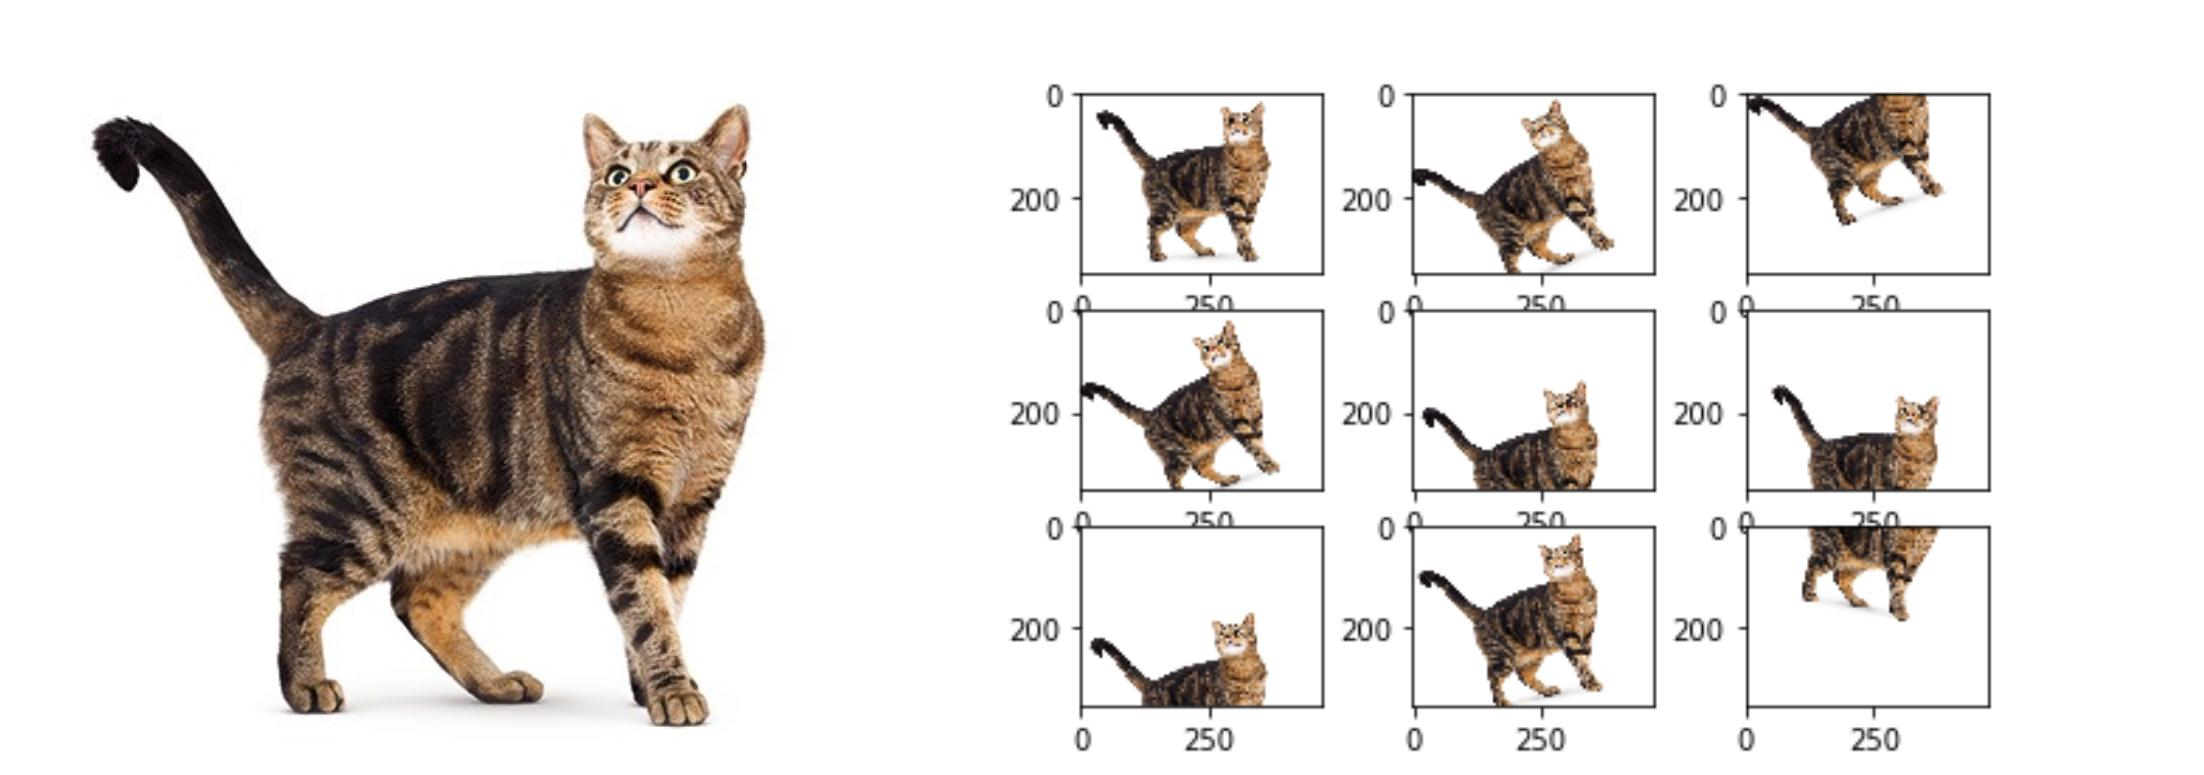

In [21]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1)
])

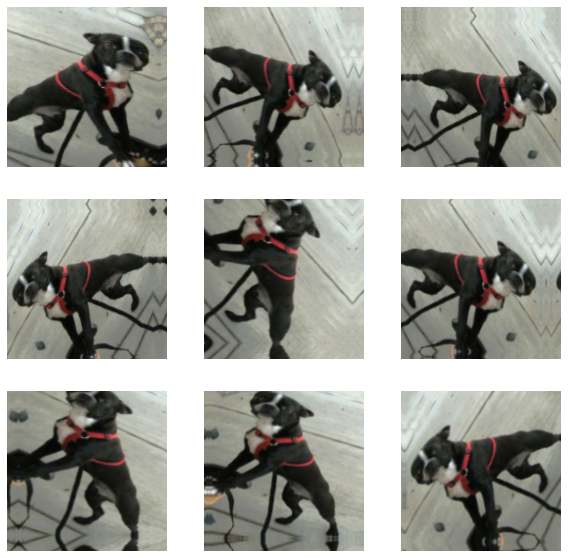

In [22]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

In [31]:
model = Sequential([
    Rescaling(1. / 255),
    data_augmentation,
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(8, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(num_classes)
])

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
tf.random.set_seed(7)
path_to_model1 = os.path.join('models', 'model1.ckpt')
path_to_history1 = os.path.join('models', 'history1.csv')

n_epochs = 30
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(path_to_model1, ),
             CSVLogger(path_to_history1, append=True)]

In [34]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=20,
                   callbacks = callbacks)

Epoch 1/20
63/63 [==============================] - 25s 388ms/step - loss: 0.6924 - accuracy: 0.5260 - val_loss: 0.6873 - val_accuracy: 0.5161
Epoch 2/20
63/63 [==============================] - 25s 389ms/step - loss: 0.6894 - accuracy: 0.5375 - val_loss: 0.6868 - val_accuracy: 0.5792
Epoch 3/20
63/63 [==============================] - 26s 409ms/step - loss: 0.6750 - accuracy: 0.5705 - val_loss: 0.6824 - val_accuracy: 0.5990
Epoch 4/20
63/63 [==============================] - 26s 418ms/step - loss: 0.6562 - accuracy: 0.6255 - val_loss: 0.7325 - val_accuracy: 0.5520
Epoch 5/20
63/63 [==============================] - 27s 422ms/step - loss: 0.6498 - accuracy: 0.5985 - val_loss: 0.6380 - val_accuracy: 0.6423
Epoch 6/20
63/63 [==============================] - 26s 413ms/step - loss: 0.6319 - accuracy: 0.6420 - val_loss: 0.6176 - val_accuracy: 0.6337
Epoch 7/20
63/63 [==============================] - 26s 409ms/step - loss: 0.6019 - accuracy: 0.6850 - val_loss: 0.6158 - val_accuracy: 0.6671

In [38]:
def learning_curves(history):
    if isinstance(history, pd.DataFrame):
        acc = history['accuracy']
        val_acc = history['val_accuracy']

        loss = history['loss']
        val_loss = history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

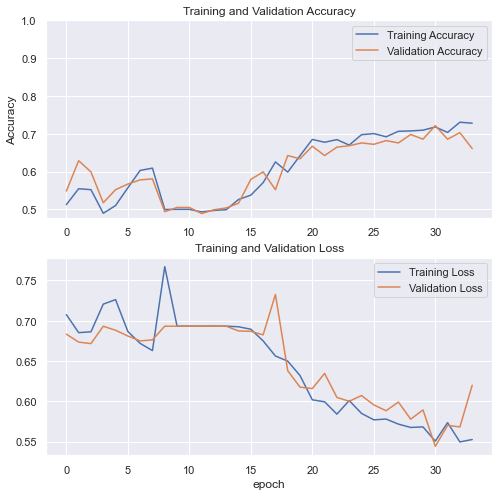

In [38]:
history = pd.read_csv(path_to_history1)
learning_curves(history)

In [39]:
model.evaluate(test_dataset)

6/6 [==============================] - 1s 85ms/step - loss: 0.7290 - accuracy: 0.5990


[0.7290312647819519, 0.5989583134651184]

# Transfer Learning

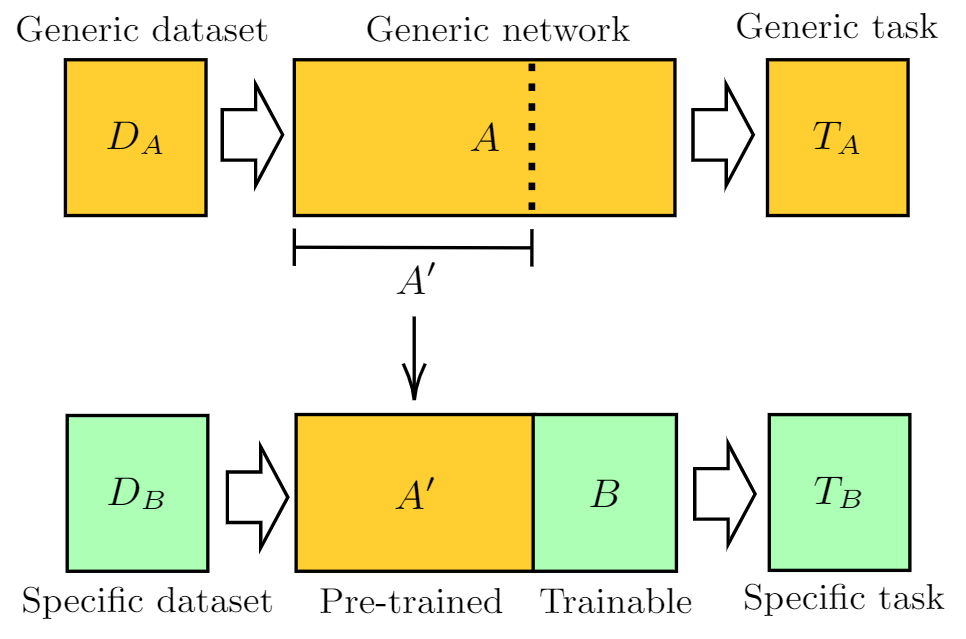

In [23]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3), 
                                               include_top=False, 
                                               weights='imagenet')

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [24]:
base_model.trainable = False

In [25]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [26]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1)
])

In [32]:
inputs = Input((160, 160, 3)) 
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes)(x)
model = Model(inputs, outputs)

In [33]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [35]:
tf.random.set_seed(7)
path_to_model2 = os.path.join('models', 'model2.ckpt')
path_to_history2 = os.path.join('models', 'history2.csv')

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(path_to_model2, ),
             CSVLogger(path_to_history2, append=True)]

In [36]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=10,
                   callbacks = callbacks,
                    batch_size=BATCH_SIZE)

Epoch 1/20
63/63 [==============================] - 48s 731ms/step - loss: 0.7508 - accuracy: 0.5975 - val_loss: 0.4603 - val_accuracy: 0.7958
Epoch 2/20
63/63 [==============================] - 44s 687ms/step - loss: 0.5090 - accuracy: 0.7455 - val_loss: 0.2926 - val_accuracy: 0.9084
Epoch 3/20
63/63 [==============================] - 46s 737ms/step - loss: 0.3930 - accuracy: 0.8255 - val_loss: 0.2112 - val_accuracy: 0.9369
Epoch 4/20
63/63 [==============================] - 45s 718ms/step - loss: 0.3388 - accuracy: 0.8510 - val_loss: 0.1738 - val_accuracy: 0.9480
Epoch 5/20
63/63 [==============================] - 46s 732ms/step - loss: 0.2984 - accuracy: 0.8685 - val_loss: 0.1437 - val_accuracy: 0.9554
Epoch 6/20
63/63 [==============================] - 48s 759ms/step - loss: 0.2703 - accuracy: 0.8865 - val_loss: 0.1292 - val_accuracy: 0.9542
Epoch 7/20
63/63 [==============================] - 48s 763ms/step - loss: 0.2477 - accuracy: 0.8955 - val_loss: 0.1134 - val_accuracy: 0.9653

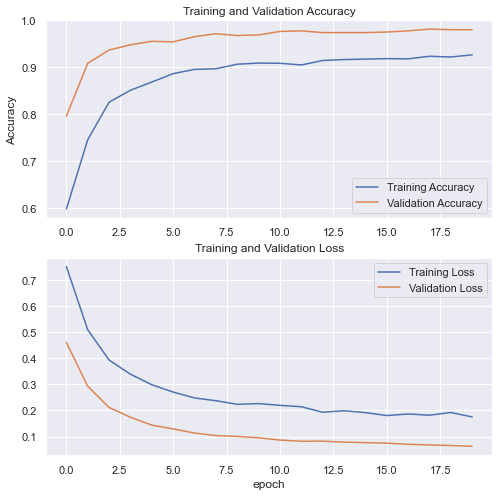

In [39]:
# history = pd.read_csv(path_to_history2)
learning_curves(history)

# Fine Tuning

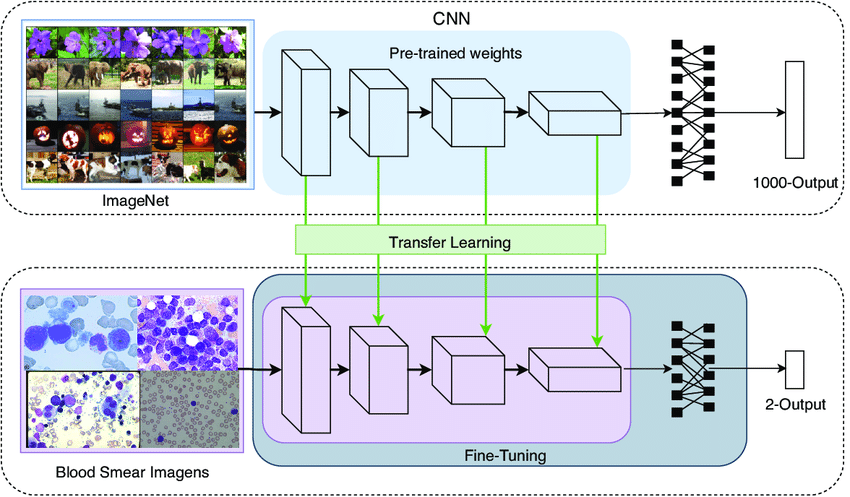

In [40]:
base_model.trainable = True

In [41]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [42]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
len(model.trainable_variables)

56

In [44]:
tf.random.set_seed(7)
path_to_model3 = os.path.join('models', 'model3.ckpt')
path_to_history3 = os.path.join('models', 'history3.csv')

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(path_to_model3, ),
             CSVLogger(path_to_history3, append=True)]

In [46]:
fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks = callbacks)

Epoch 20/20
63/63 [==============================] - 58s 922ms/step - loss: 0.1549 - accuracy: 0.9395 - val_loss: 0.0464 - val_accuracy: 0.9851


In [ ]:
# history = pd.read_csv(path_to_history3)
learning_curves(history)